## Initialisation

In [7]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\ode-biomarker-project


In [8]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [9]:
core_used = 24
normalised = True
save_model = True
fixed_random_seed = 42  # -1 for no seed, NOT IN USE
save_figure = False
save_data = True
show_figure = False
rngs = list(range(100)) # for stable rng, for pure random, a random set can be used

In [10]:
# dynamic_data_code = 'fgfr4_ccle_dynamic_features_v2'
# drug_code = 'gdsc-1-FGFR_0939'
# match_rules_data_code = 'fgfr4_model_ccle_match_rules'
# folder_name = "FGFR4-combined-model-training"
# exp_id = "fgfr4_v4"  # experiment id, fgfr4_v1, cdk46_v1

In [11]:
dynamic_data_code = 'cdk46_ccle_dynamic_features_v3'
drug_code = 'gdsc-2-Palbociclib'
match_rules_data_code = 'cdk_model_match_rules'
folder_name = "CDK46-combined-model-training"
exp_id = "cdk46_v4" # experiment id, fgfr4_v1, cdk46_v1

In [12]:
# load in dynamic features data 
loading_code = f'generic-{drug_code}-LN_IC50-{dynamic_data_code}-true-Unnamed: 0'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
dynamic_feature_data, dynamic_label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code} Feature Shape {dynamic_feature_data.shape} Label Shape {dynamic_label_data.shape}')

# load in ccle static gene expression data
loading_code = f'ccle-{drug_code}-LN_IC50'
feature_data, label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code} Feature Shape {feature_data.shape} Label Shape {label_data.shape}')

match_rules = data_link.get_data_from_code(match_rules_data_code)

Data loaded for code generic-gdsc-2-Palbociclib-LN_IC50-cdk46_ccle_dynamic_features_v3-true-Unnamed: 0 Feature Shape (584, 590) Label Shape (584,)
Data loaded for code ccle-gdsc-2-Palbociclib-LN_IC50 Feature Shape (584, 19221) Label Shape (584,)


In [13]:
from toolkit import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [14]:
all_models = ['SVR', 'RandomForestRegressor', 'XGBRegressor', 'MLPRegressor', 'KNeighborsRegressor', 'ElasticNet']

if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

In [15]:
# remove samples present in feature data but not in dynamic feature data
new_feature_data = feature_data.loc[feature_data.index.isin(dynamic_feature_data.index)]
new_label_data = label_data.loc[label_data.index.isin(dynamic_feature_data.index)]

# check size 
print(new_feature_data.shape)
print(new_label_data.shape)

(584, 19221)
(584,)


In [16]:
combined_feature_data = pd.concat([new_feature_data, dynamic_feature_data], axis=1)
combined_label_data = new_label_data

In [17]:
combined_feature_data

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,CDK2ccCYCEccP27p_auc,CDK2ccCYCEccP27p_median,CDK2ccCYCEccP27p_tfc,CDK2ccCYCEccP27p_tmax,CDK2ccCYCEccP27p_max,CDK2ccCYCEccP27p_tmin,CDK2ccCYCEccP27p_min,CDK2ccCYCEccP27p_ttsv,CDK2ccCYCEccP27p_tsv,CDK2ccCYCEccP27p_init
SIDM00872,5.296090,0.000000,6.794416,3.452859,5.260778,0.042644,4.339137,5.833143,7.313246,4.764474,...,0.004366,0.004577,0.605010,0.967742,0.004583,0.0,0.002856,0.032258,0.002856,0.002856
SIDM00866,5.214125,0.000000,6.328047,3.168321,4.654206,0.042644,0.432959,6.574102,5.140779,5.114783,...,0.004215,0.004457,1.130657,0.967742,0.004466,0.0,0.002096,0.032258,0.002096,0.002096
SIDM00885,5.241840,0.201634,5.615299,3.090853,3.732269,0.084064,0.111031,4.026800,5.471513,6.019480,...,0.004297,0.004550,0.989570,0.967742,0.004551,0.0,0.002288,0.032258,0.002288,0.002288
SIDM00884,3.481557,0.000000,7.070389,2.341986,3.679199,0.176323,3.420887,5.854494,5.976134,5.112283,...,0.004537,0.004764,0.350453,0.967742,0.004774,0.0,0.003535,0.032258,0.003535,0.003535
SIDM00874,4.903038,0.000000,7.177719,2.744161,4.648465,0.150560,0.070389,5.819924,4.374344,3.814550,...,0.004449,0.004674,0.639426,0.967742,0.004685,0.0,0.002858,0.032258,0.002858,0.002858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM00741,5.054848,0.000000,6.229588,2.805292,4.458776,0.189034,0.028569,0.650765,3.883621,5.510012,...,0.003852,0.004156,1.026422,0.967742,0.004186,0.0,0.002066,0.032258,0.002066,0.002066
SIDM00760,5.282810,0.000000,6.273516,3.090853,5.070389,0.310340,0.124328,2.950468,3.889474,5.275380,...,0.003763,0.004073,1.328825,0.967742,0.004097,0.0,0.001759,0.032258,0.001759,0.001759
SIDM00273,4.631104,0.000000,6.685940,2.739848,4.545968,0.028569,1.007196,6.046797,4.066950,4.890447,...,0.004359,0.004593,2.175721,0.967742,0.004600,0.0,0.001449,0.032258,0.001449,0.001449
SIDM00560,5.127221,0.000000,7.304146,1.782409,4.192983,0.137504,0.189034,6.446422,4.791814,3.723559,...,0.004616,0.004870,0.681136,0.967742,0.004884,0.0,0.002905,0.032258,0.002905,0.002905


In [18]:
def normalise_data(data): 
    data = (data - data.mean()) / data.std()
    return data

def pipeline_func(X_train, y_train, rng, model_used, normalised=False, **kwargs):
    # impute missing values by first quantile first 
    # normalise X_train 
    if normalised:
        X_train = normalise_data(X_train)
    X_train, _ = impute_by_first_quantile(X_train, y_train)
    k = X_train.shape[1]
    if k > 500: 
        k = 500 # limit the number of features to 500
    selected_features, scores = f_regression_select(X_train, y_train, k)
    model = get_model_from_string(model_used, **kwargs)
    selected_features, X_selected = select_preset_features(X_train, y_train, selected_features)
    # print(f'{rng} {model_used}')
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': scores}


def eval_func(X_test, y_test, pipeline_components=None, 
              normalised=False,
              save_model=False, 
              **kwargs):
    if normalised:
        X_test = (X_test - X_test.mean()) / X_test.std()
    X_test, _ = impute_by_first_quantile(X_test, y_test)
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    returned_data = {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp}
    if save_model:
        returned_data['model'] = pipeline_components['model']
    return returned_data

def eval_func_best(X_test, y_test, pipeline_components=None, normalised=False, **kwargs):
    if normalised:
        X_test = (X_test - X_test.mean()) / X_test.std()
    X_test, _ = impute_by_first_quantile(X_test, y_test)
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp, 'y_test': y_test, 'y_pred': y_pred}

#### custom pipelines

In [19]:
def pipeline_select_genes_only(X_train, y_train, rng, model_used, keep_features, normalised=False, **kwargs):
    if normalised:
        X_train = normalise_data(X_train)
    X_train, _ = impute_by_first_quantile(X_train, y_train)
    final_selected_features = keep_features
    dynamic_X_train = X_train[final_selected_features]
    static_X_train = X_train.drop(final_selected_features, axis=1)
    k = X_train.shape[1]
    if k > 500:
        k = 500  # limit the number of features to 500
    selected_features, scores = f_regression_select(static_X_train, y_train, k)
    for f in selected_features:
        final_selected_features.append(f)
    selected_X_train = X_train[final_selected_features]
    model = get_model_from_string(model_used, **kwargs)
    model.fit(selected_X_train, y_train)
    return {'model': model,
            'filter_selected_features': final_selected_features,
            'filter_scores': scores}

In [20]:
def pipeline_select_only(X_train, y_train, rng, model_used, 
                                     keep_features, limit_features = False, 
                         normalised=False, **kwargs):
    if normalised:
        X_train = normalise_data(X_train)
    X_train, _ = impute_by_first_quantile(X_train, y_train)
    final_selected_features = keep_features
    selected_X_train = X_train[final_selected_features]
    # get the scores for the selected features using f_regression
    k = selected_X_train.shape[1]
    if limit_features:
        if k > 500:
            k = 500  # limit the number of features to 500
    _, scores = f_regression_select(selected_X_train, y_train, k)
    model = get_model_from_string(model_used, **kwargs)
    model.fit(selected_X_train, y_train)
    return {'model': model,
            'filter_selected_features': final_selected_features,
            'filter_scores': scores}

In [21]:
transformed_gene_list = [] 
# we deduce these from the original match rules file

gene_match_rules = match_rules.dropna(subset=['reference'])
for index, row in gene_match_rules.iterrows():
    gene = row['reference'].split(';')
    for g in gene:
        if g not in transformed_gene_list:
            transformed_gene_list.append(g)    
            
dynamic_features = list(dynamic_feature_data.columns)
transformed_dynamic_features = []
for f in dynamic_features:
    transformed_dynamic_features.append(f)
for g in transformed_gene_list:
    if g not in transformed_dynamic_features:
        transformed_dynamic_features.append(g)
        
print(f'Length of transformed gene features: {len(transformed_gene_list)}')
print(f'Length of transformed dynamic features: {len(transformed_dynamic_features)}')

Length of transformed gene features: 39
Length of transformed dynamic features: 629


## Analysis

### Initialisation

In [22]:
import pickle
experiments = ['control_dynamic',
               'specie_genes', 'specie_genes_dynamic',
               'select_gene_dynamic', 'combined']

model_used = "RandomForestRegressor"

df_list_total = []
for exp in experiments:
    df_list = []
    df = pd.read_pickle(f'{file_save_path}{exp_id}_{model_used}_{exp}.pkl')
    print(f'Loaded {model_used} for {exp}')
    df_list.append(df)

    # join all the dataframes
    df_all = pd.concat(df_list, axis=0)
    df_all['experiment'] = exp
    df_list_total.append(df_all)

total_df = pd.concat(df_list_total, axis=0)
# total_df

Loaded RandomForestRegressor for control_dynamic
Loaded RandomForestRegressor for specie_genes
Loaded RandomForestRegressor for specie_genes_dynamic
Loaded RandomForestRegressor for select_gene_dynamic
Loaded RandomForestRegressor for combined


In [23]:
# for each model, create a dataframe with the feature importance of all features 

all_new_feat_imp = []
for index, row in total_df.iterrows():
    model = row['model']
    # print(model, row['condition'], row['rng'], row['experiment'])
    importances = model.feature_importances_.tolist()
    feature_names = row['feature_importance'][0]
    # make index a repeat of index over the number of features
    feat_imp = (feature_names, importances)
    all_new_feat_imp.append(feat_imp)
    
total_df.insert(4, 'tree_feature_importance', all_new_feat_imp)
    

### Specific Loading

In [24]:
powerkit = Powerkit(new_feature_data, new_label_data)
exp_condition = 'select_gene_dynamic'
# rename the 'experiment' column to 'condition' and 'condition' to 'model_name' 
total_df['model_name'] = total_df['condition']
total_df['condition'] = total_df['experiment']
mean_contribution = powerkit.get_mean_contribution(total_df, 
                                                   exp_condition, 
                                                   'tree_feature_importance', 
                                                   strict_mean=0.75)
mean_variation = get_variation(total_df, exp_condition, 
                               col_name='tree_feature_importance', 
                               use_iqr=False)

In [25]:
mean_contribution.shape

(1024, 3)

In [26]:
mean_variation.shape

(1024, 4)

In [27]:
# join the two dataframes
mean_df = mean_contribution.join(mean_variation, rsuffix='_variation')

In [28]:
mean_df.head(10)

,iteration_no,scores,count,variability_score,std,mean,count_variation
feature_names,,,,,,,
WAS,49.500000,0.066549,100,0.473869,0.031536,0.066549,100
TJP1,49.500000,0.064789,100,0.458939,0.029734,0.064789,100
PXDC1,49.500000,0.033890,100,0.513585,0.017406,0.033890,100
BCL2L1,49.755102,0.021466,98,0.272287,0.005845,0.021466,98
RPL3,49.500000,0.020303,100,0.467970,0.009501,0.020303,100
PPIC,49.500000,0.017142,100,0.710696,0.012182,0.017142,100
LAMA5,49.500000,0.015050,100,0.334118,0.005028,0.015050,100
CCN1,49.500000,0.011200,100,0.788462,0.008831,0.011200,100
CAP2,49.500000,0.011167,100,0.844714,0.009433,0.011167,100


In [29]:
import seaborn as sns
condition_df = total_df[total_df['condition'] == exp_condition]
data = condition_df['tree_feature_importance']

# extract the feature names and scores from the feature importance column
feature_names = []
scores = []

for row in data:
    feature_names.append(row[0])
    scores.append(row[1])

print(len(feature_names), len(scores))

feature_names_all = []
scores_all = []

for feature_name, score in zip(feature_names, scores):
    for feature, score in zip(feature_name, score):
        feature_names_all.append(feature)
        scores_all.append(score)

print(len(feature_names_all), len(scores_all))

# create a dataframe from the feature names and scores
df = pd.DataFrame({'feature_names': feature_names_all, 'scores': scores_all})

df.head()


100 100
109000 109000


,feature_names,scores
0,INSR_auc,0.000039
1,INSR_median,0.000073
2,INSR_tfc,0.000467
3,INSR_tmax,0.000000
4,INSR_max,0.000156


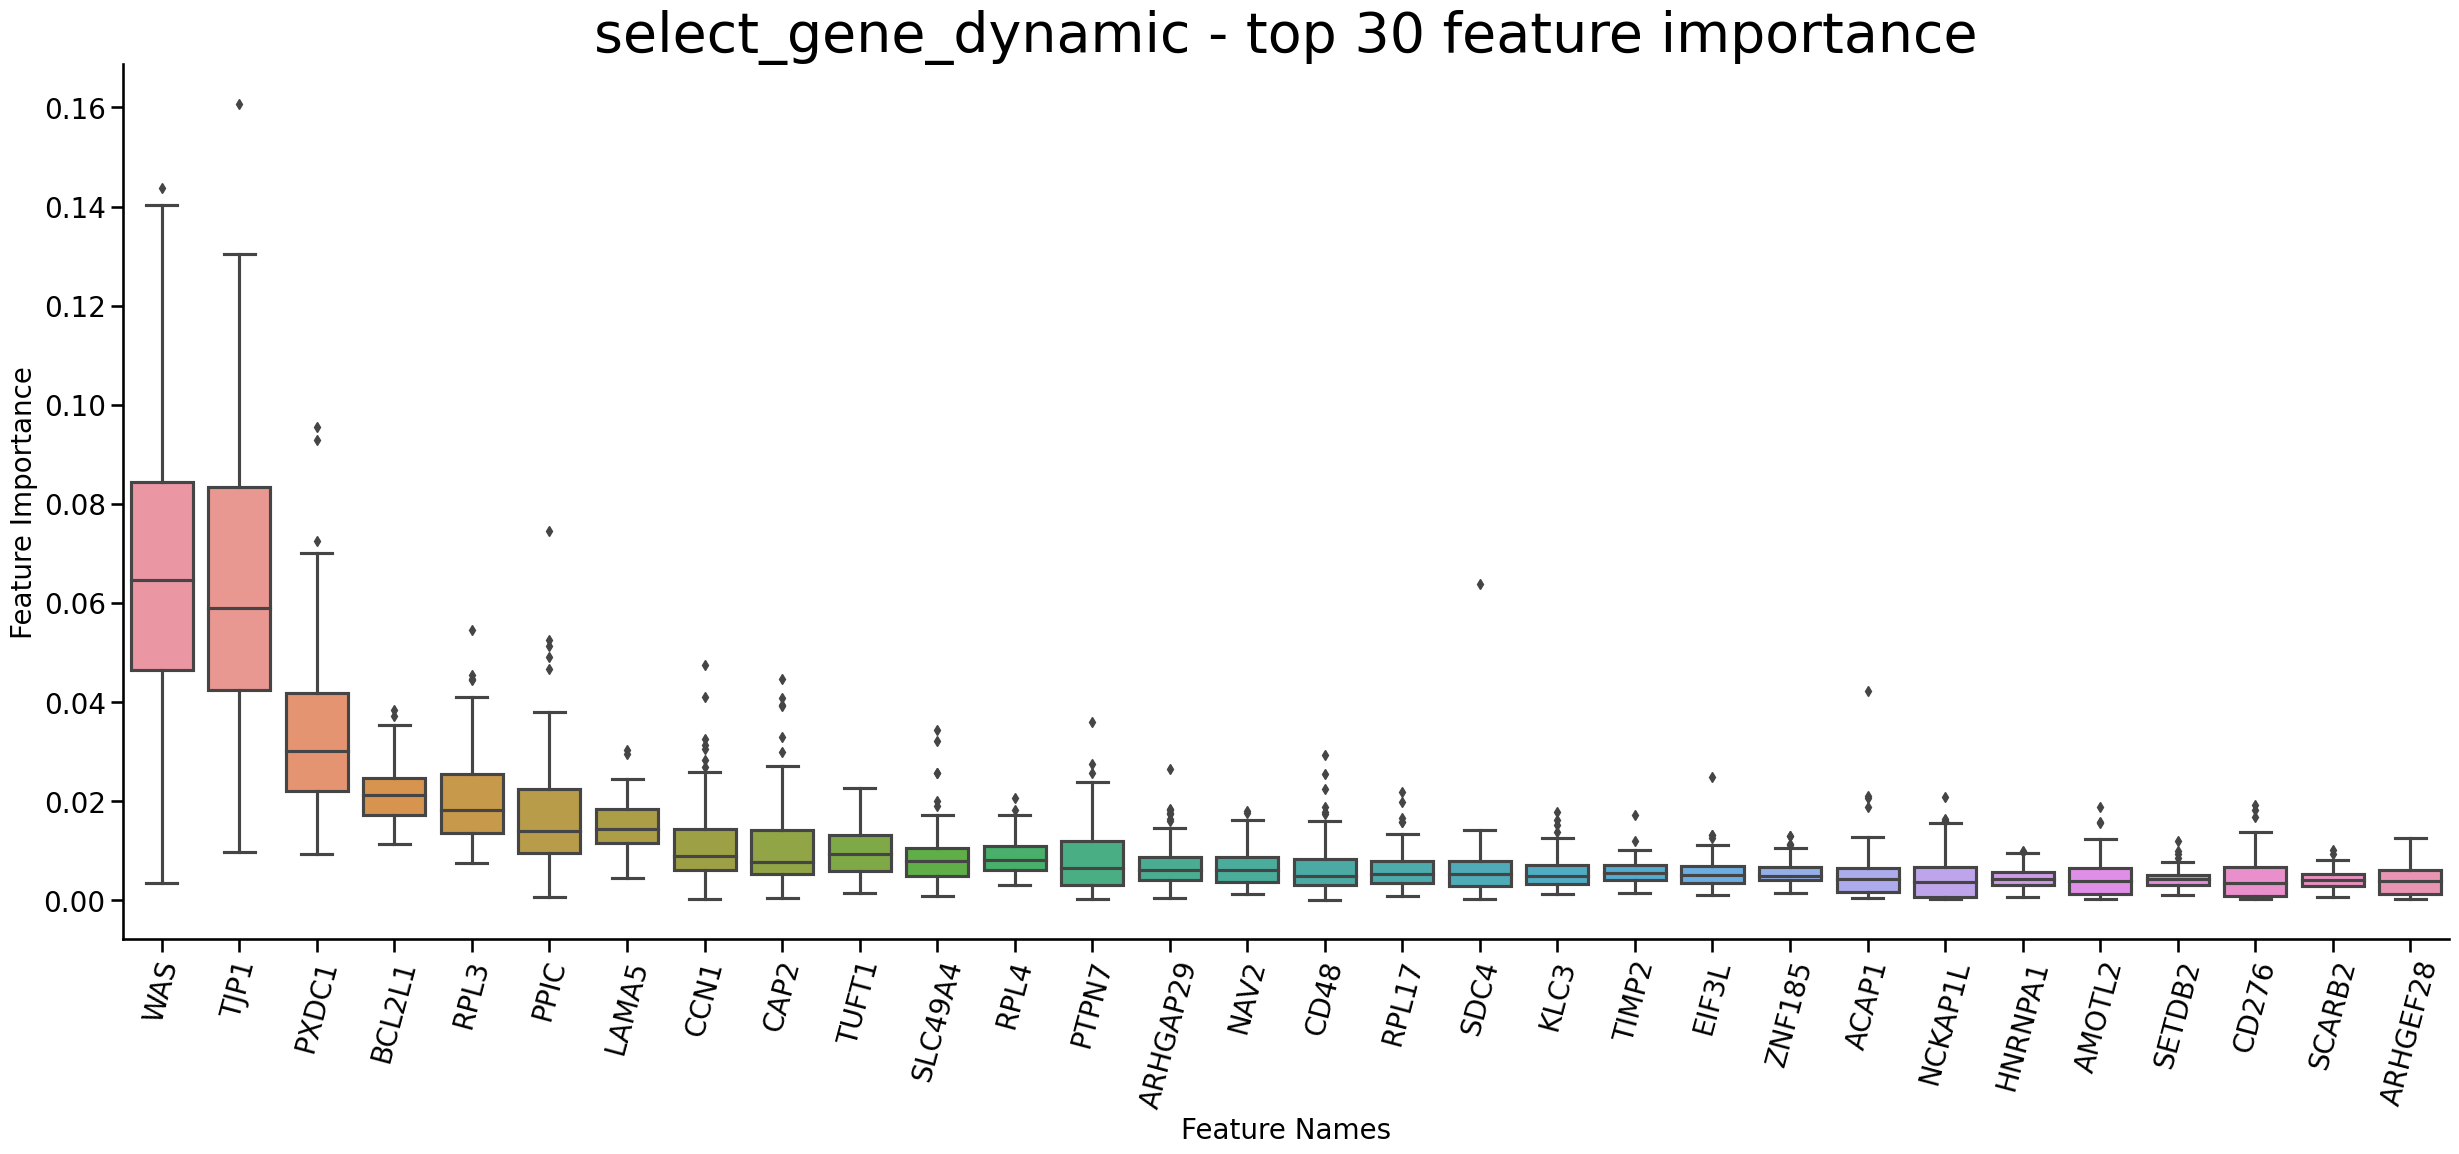

In [30]:
features_to_include = mean_df.index[:30]

# filter the dataframe by the features to include
filtered_df = df[df['feature_names'].isin(features_to_include)]

plot_order = filtered_df.groupby('feature_names').mean().sort_values('scores', ascending=False).index

sns.set_context('talk')

# plot the boxplot
sns.catplot(x='feature_names', y='scores', data=filtered_df, kind='box', height=10, aspect=2.5, order=plot_order)

# enlarge the x axis labels and y axis labels
plt.xlabel('Feature Names', fontsize=20)
plt.ylabel('Feature Importance', fontsize=20)
plt.title(f'{exp_condition} - top 30 feature importance', fontsize=40)
plt.xticks(rotation=75, fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### Compare between specie genes vs dynamic features 

In [31]:
powerkit = Powerkit(new_feature_data, new_label_data)
exp_condition = 'specie_genes_dynamic'

# rename the 'experiment' column to 'condition' and 'condition' to 'model_name'
total_df['model_name'] = total_df['condition']
total_df['condition'] = total_df['experiment']
mean_contribution = powerkit.get_mean_contribution(total_df,
                                                   exp_condition,
                                                   'tree_feature_importance',
                                                   strict_mean=0.75)
mean_variation = get_variation(total_df, exp_condition,
                               col_name='tree_feature_importance',
                               use_iqr=False)

In [32]:
match_rules_files_dropna = match_rules.dropna(subset=['reference'])

species_ccle_matches = {}
for i in range(len(match_rules_files_dropna)):
    row = match_rules_files_dropna.iloc[i]
    specie_name = row['specie']
    ccle_matches = row['reference']
    ccle_matches = ccle_matches.split(';')
    print(f'{specie_name}: {ccle_matches}')
    species_ccle_matches[specie_name] = ccle_matches

AKT: ['AKT3', 'AKT2', 'AKT1']
CDK2: ['CDK2']
CDK46: ['CDK6', 'CDK4']
CYCD: ['CCND1', 'CCND2', 'CCND3']
CYCE: ['CCNE1', 'CCNE2']
E2F: ['E2F8', 'E2F7', 'E2F6']
ERK: ['MAPK7', 'MAPK8', 'MAPK9']
GSK3B: ['GSK3B']
INSR: ['INSR']
IRS: ['IRS4', 'IRS2', 'IRS1']
MTORC1: ['RPTOR']
MTORC2: ['RICTOR']
MYC: ['MYC']
P21: ['CDKN1A']
P27: ['CDKN1B']
PDK1: ['PDK1']
PI3K: ['PIK3CA', 'PIK3CD', 'PIK3CB', 'PIK3CG']
RAF: ['RAF1', 'BRAF', 'ARAF']
RB: ['RB1']
S6K: ['RPS6KB1']
SOS: ['SOS2', 'SOS1']


In [33]:
dynamic_feature_label = ['auc', 'median', 'tfc', 'tmax', 'max', 'tmin', 'min', 'ttsv', 'tsv', 'init']

dynamic_feature_ccle_map = {}
for key, value in species_ccle_matches.items():
    dyn_feats = dynamic_feature_data.filter(regex=f'^{key}'+'_', axis=1).columns.tolist()
    dynamic_feature_ccle_map[key] = dyn_feats
    # print(f'{key}: {dyn_feats}')
    

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


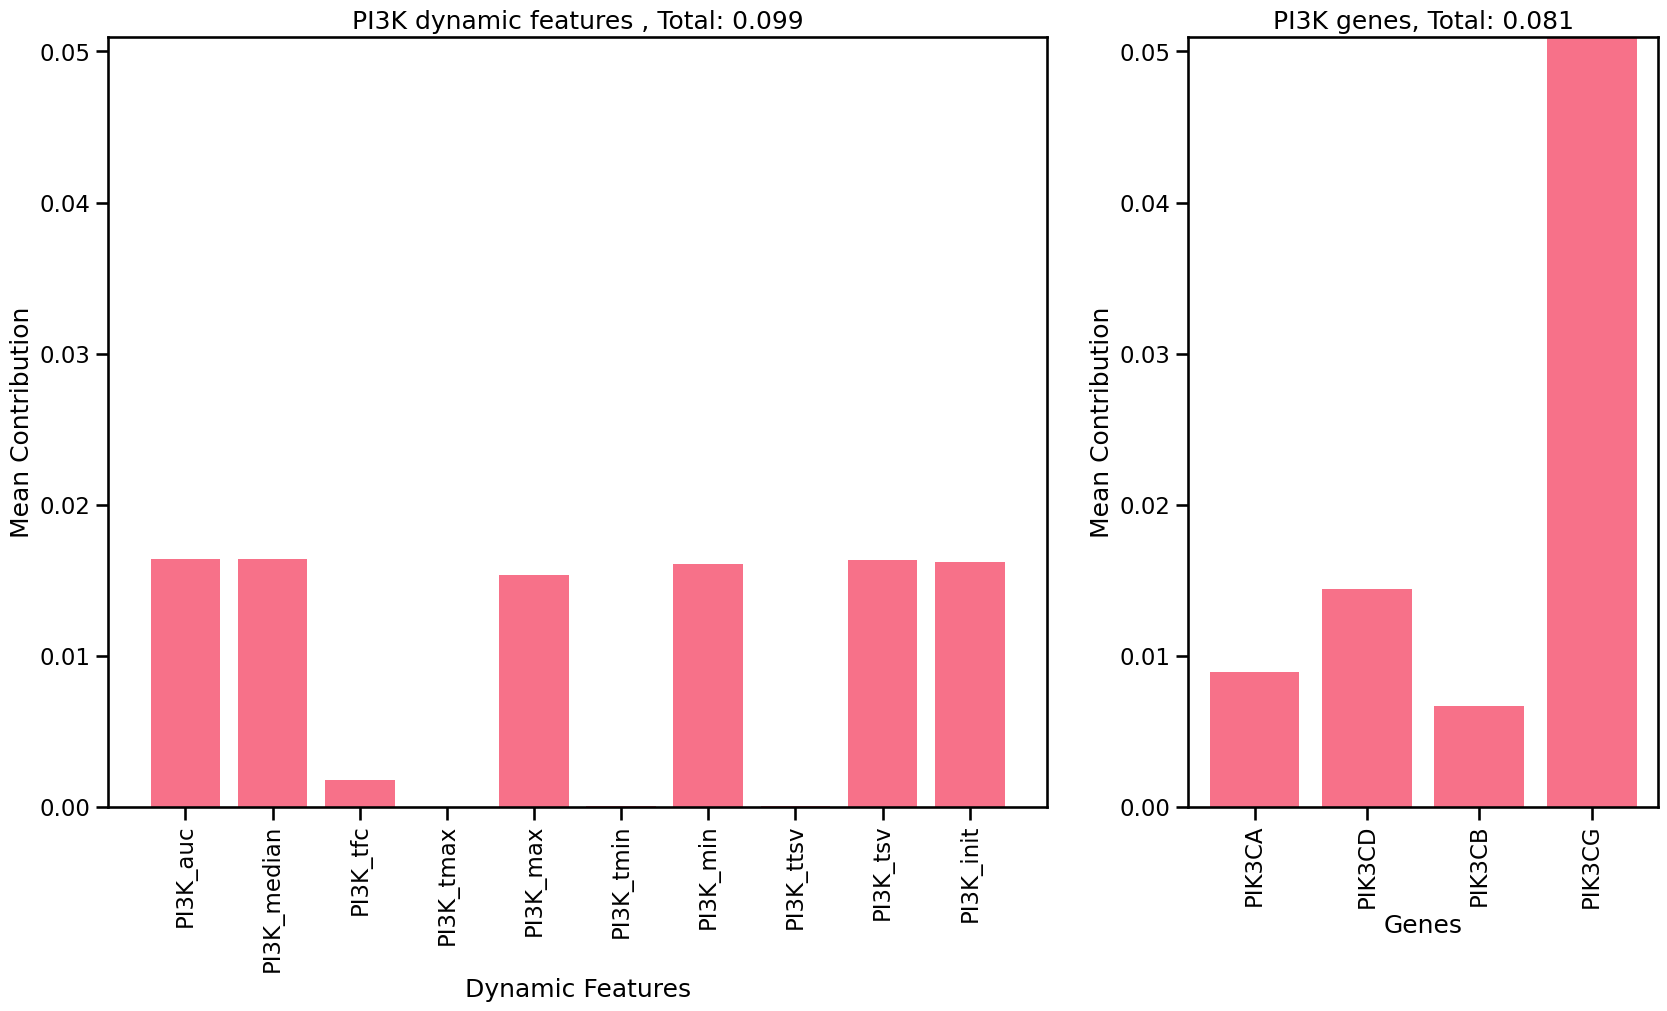

In [34]:
test_specie = 'PI3K'

import matplotlib.pyplot as plt
import seaborn as sns

# find contribution scores for the dynamic features for AKT 

dynamic_features = dynamic_feature_ccle_map[test_specie]
dyn_contribs = []
for dyn_feats in dynamic_features:
    mean = mean_contribution.loc[dyn_feats]
    dyn_contribs.append(mean["scores"])
    # print(f'{dyn_feats}: {mean["scores"]}')
    
genes = species_ccle_matches[test_specie]
ccle_contribs = []
for g in genes:
    mean = mean_contribution.loc[g]
    ccle_contribs.append(mean["scores"])
    # print(f'{g}: {mean["scores"]}')
    
highest = max(dyn_contribs) if max(dyn_contribs) > max(ccle_contribs) else max(ccle_contribs)
    
# plot a multi-plot bar chart for the dynamic features and the genes
sns.set_context('talk')
sns.set_palette('husl')
fig, (a0, a1) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [2, 1]})

a0.bar(dynamic_features, dyn_contribs)
a0.set_title(f'{test_specie} dynamic features , Total: {sum(dyn_contribs):.3f}')
a0.set_ylabel('Mean Contribution')
a0.set_xlabel('Dynamic Features')
a0.set_xticklabels(dynamic_features, rotation=90)
# set y axis limits
a0.set_ylim(0, highest)

a1.bar(genes, ccle_contribs)
a1.set_title(f'{test_specie} genes, Total: {sum(ccle_contribs):.3f}')
a1.set_ylabel('Mean Contribution')
a1.set_xlabel('Genes')
a1.set_xticklabels(genes, rotation=90)
a1.set_ylim(0, highest)

plt.show()




    
    

In [ ]:
save_folder_name = "AN17_tree_contribution_analysis"

In [45]:

all_avgs_dyn = []
all_avgs_genes = []
all_max_dyn = []
all_max_genes = []

for key, value in species_ccle_matches.items():
    dynamic_features = dynamic_feature_ccle_map[key]
    dyn_contribs = []
    for dyn_feats in dynamic_features:
        mean = mean_contribution.loc[dyn_feats]
        dyn_contribs.append(mean["scores"])
        # print(f'{dyn_feats}: {mean["scores"]}')
        
    average_score_dyn = sum(dyn_contribs) / len(dyn_contribs)
    all_avgs_dyn.append(average_score_dyn)
    max_score_dyn = max(dyn_contribs)
    all_max_dyn.append(max_score_dyn)
        
    genes = species_ccle_matches[key]
    ccle_contribs = []
    for g in genes:
        mean = mean_contribution.loc[g]
        ccle_contribs.append(mean["scores"])
        # print(f'{g}: {mean["scores"]}')
        
    average_score_genes = sum(ccle_contribs) / len(ccle_contribs)
    all_avgs_genes.append(average_score_genes)
    max_score_genes = max(ccle_contribs)
    all_max_genes.append(max_score_genes)
    
    # print(f'{key} dynamic features average score: {average_score_dyn} genes average score: {average_score_genes}')
    


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


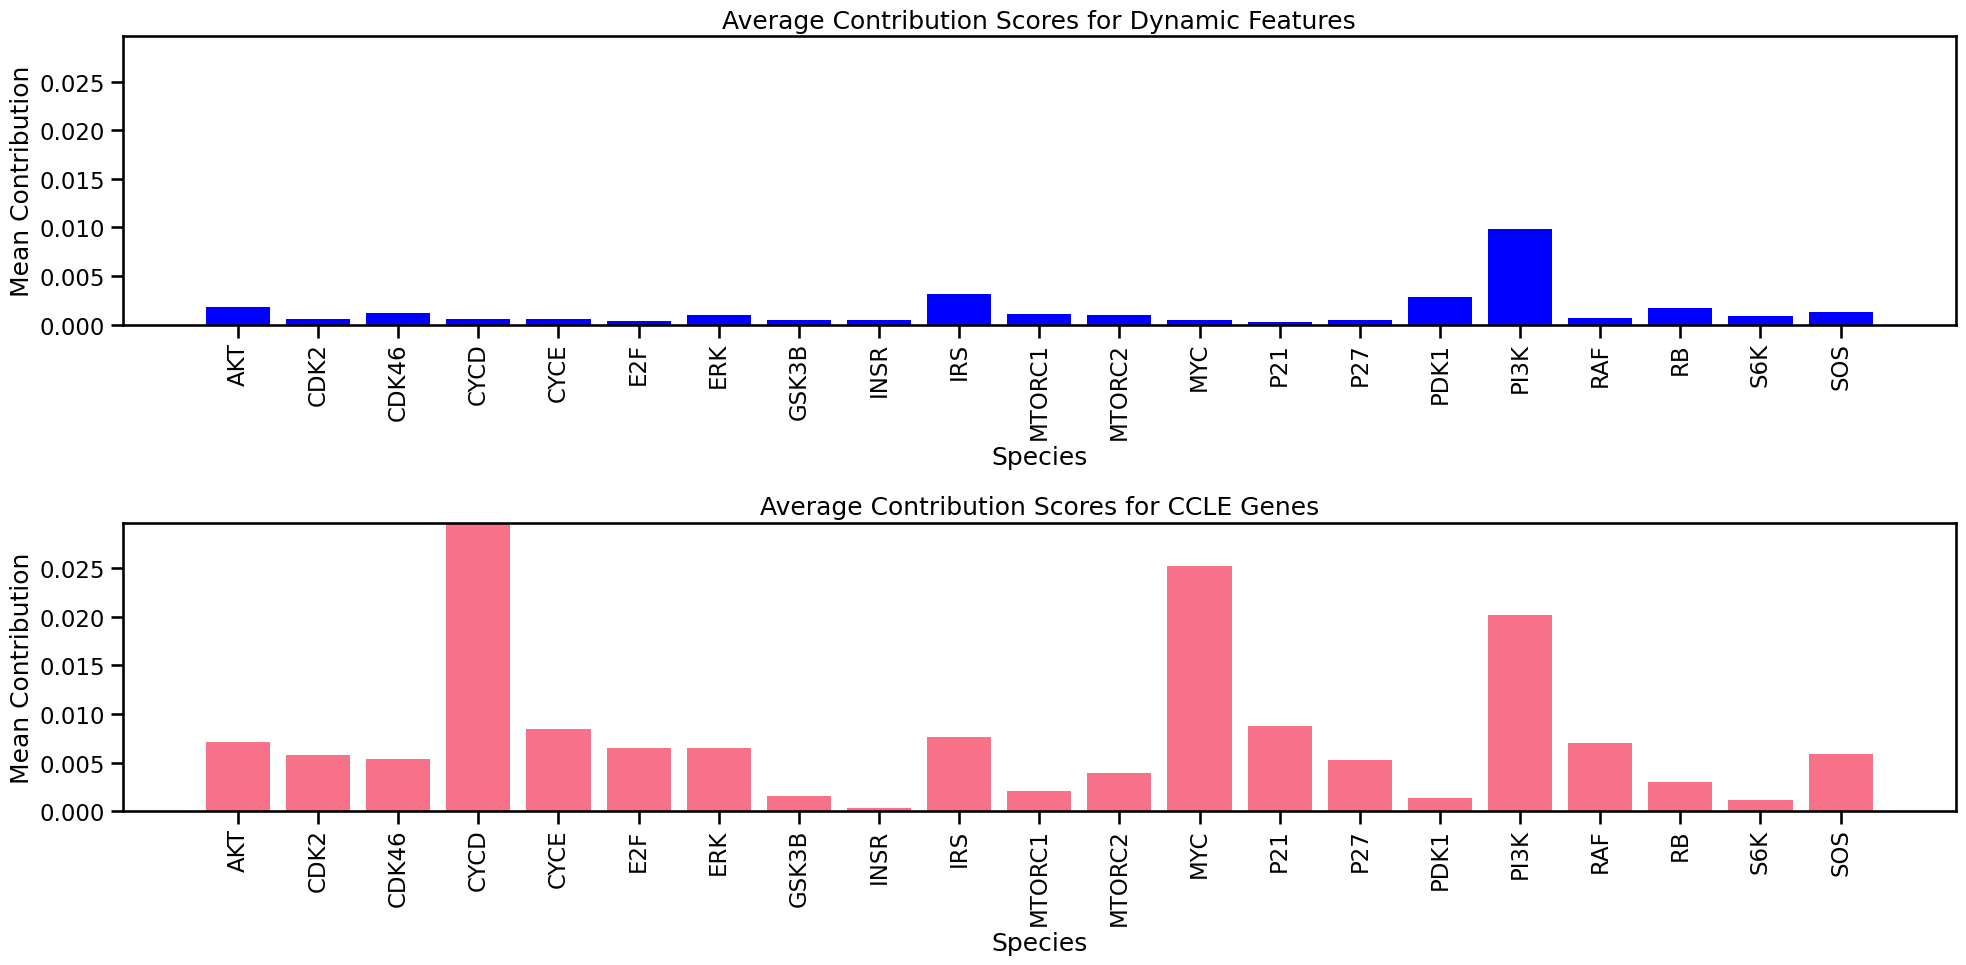

In [60]:
#  plot the average scores for the dynamic features and the genes, for each specie 

sns.set_context('talk')
sns.set_palette('husl')
fig, (a0, a1) = plt.subplots(2, 1, figsize=(20, 10))


highest = max(all_avgs_dyn) if max(all_avgs_dyn) > max(all_avgs_genes) else max(all_avgs_genes)
a0.bar(species_ccle_matches.keys(), all_avgs_dyn, color='blue')
a0.set_title('Average Contribution Scores for Dynamic Features')
a0.set_ylabel('Mean Contribution')
a0.set_xlabel('Species')
a0.set_xticklabels(species_ccle_matches.keys(), rotation=90)
a0.set_ylim(0, highest)

a1.bar(species_ccle_matches.keys(), all_avgs_genes)
a1.set_title('Average Contribution Scores for CCLE Genes')
a1.set_ylabel('Mean Contribution')
a1.set_xlabel('Species')
a1.set_xticklabels(species_ccle_matches.keys(), rotation=90)
a1.set_ylim(0, highest)

plt.tight_layout()
plt.show()
    
    
    
    

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


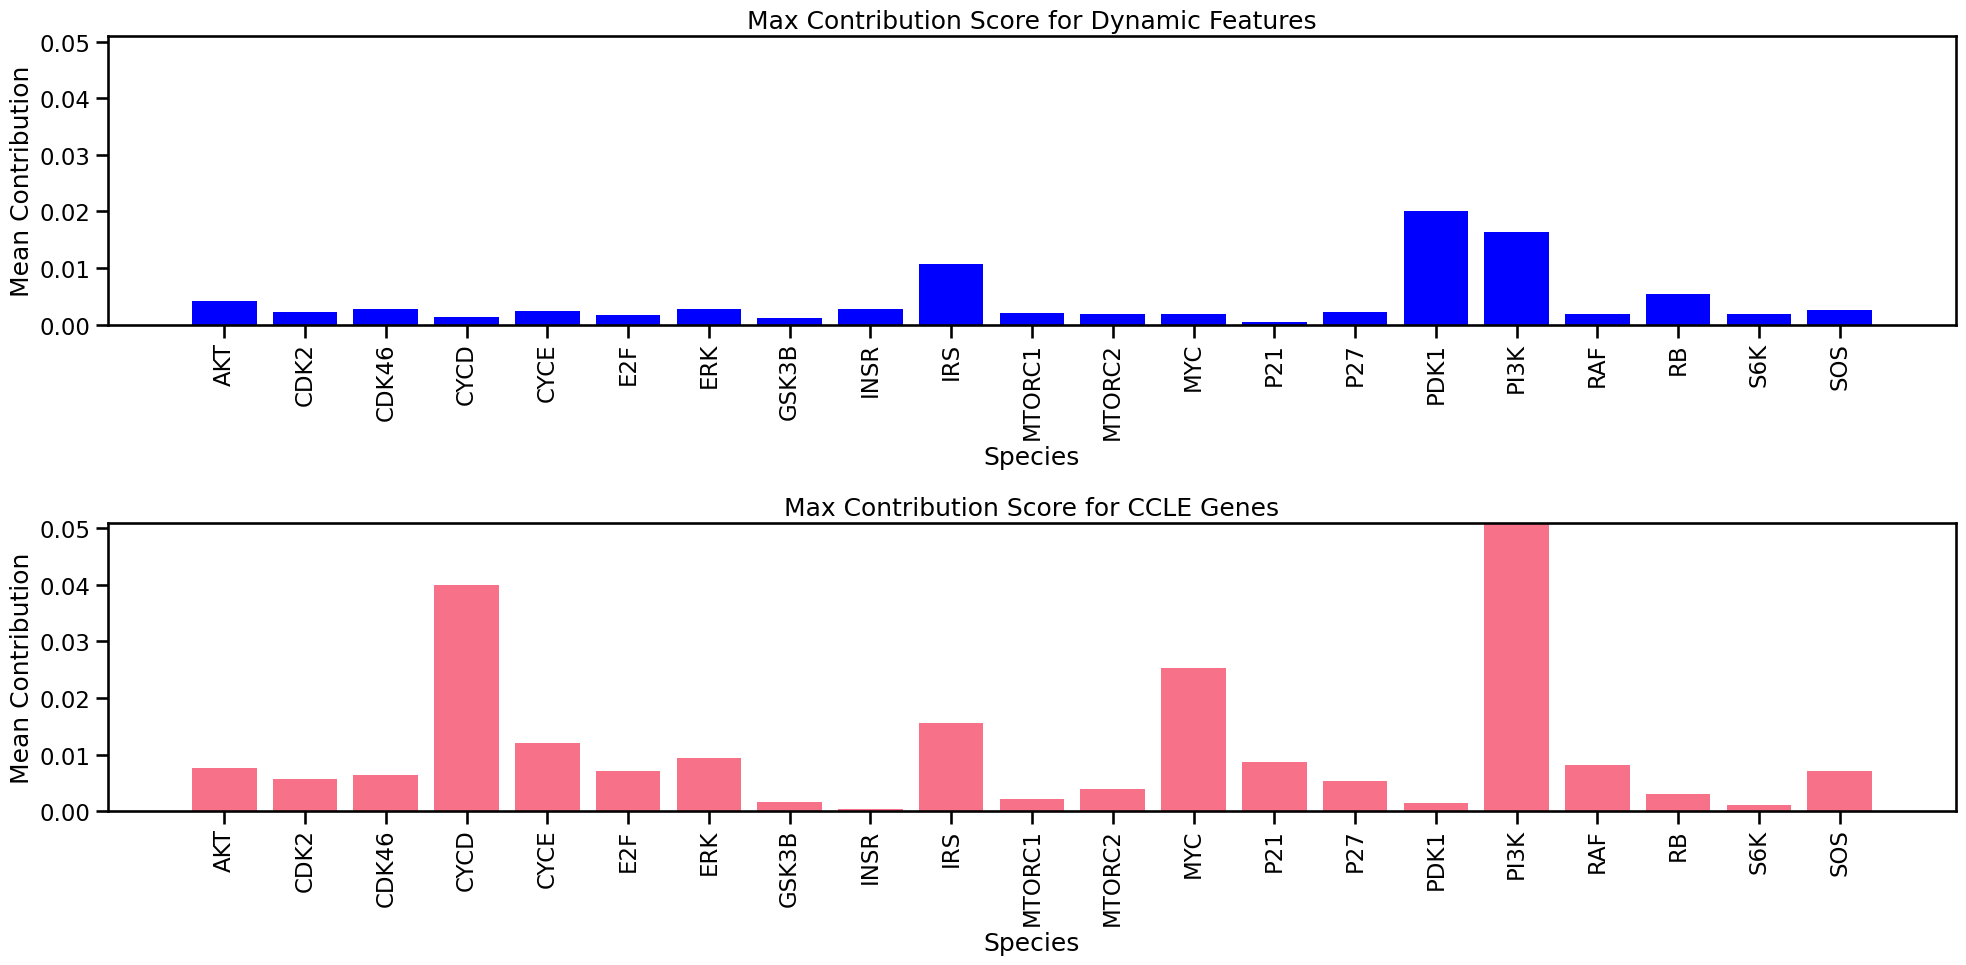

In [48]:
#  plot the max scores for the dynamic features and the genes, for each specie

sns.set_context('talk')
sns.set_palette('husl')
fig, (a0, a1) = plt.subplots(2, 1, figsize=(20, 10))

highest = max(all_max_dyn) if max(all_max_dyn) > max(all_max_genes) else max(all_max_genes)
a0.bar(species_ccle_matches.keys(), all_max_dyn, color='blue')
a0.set_title('Max Contribution Score for Dynamic Features')
a0.set_ylabel('Mean Contribution')
a0.set_xlabel('Species')
a0.set_xticklabels(species_ccle_matches.keys(), rotation=90)
a0.set_ylim(0, highest)

a1.bar(species_ccle_matches.keys(), all_max_genes)
a1.set_title('Max Contribution Score for CCLE Genes')
a1.set_ylabel('Mean Contribution')
a1.set_xlabel('Species')
a1.set_xticklabels(species_ccle_matches.keys(), rotation=90)
a1.set_ylim(0, highest)

plt.tight_layout()
plt.show()

FixedFormatter should only be used together with FixedLocator


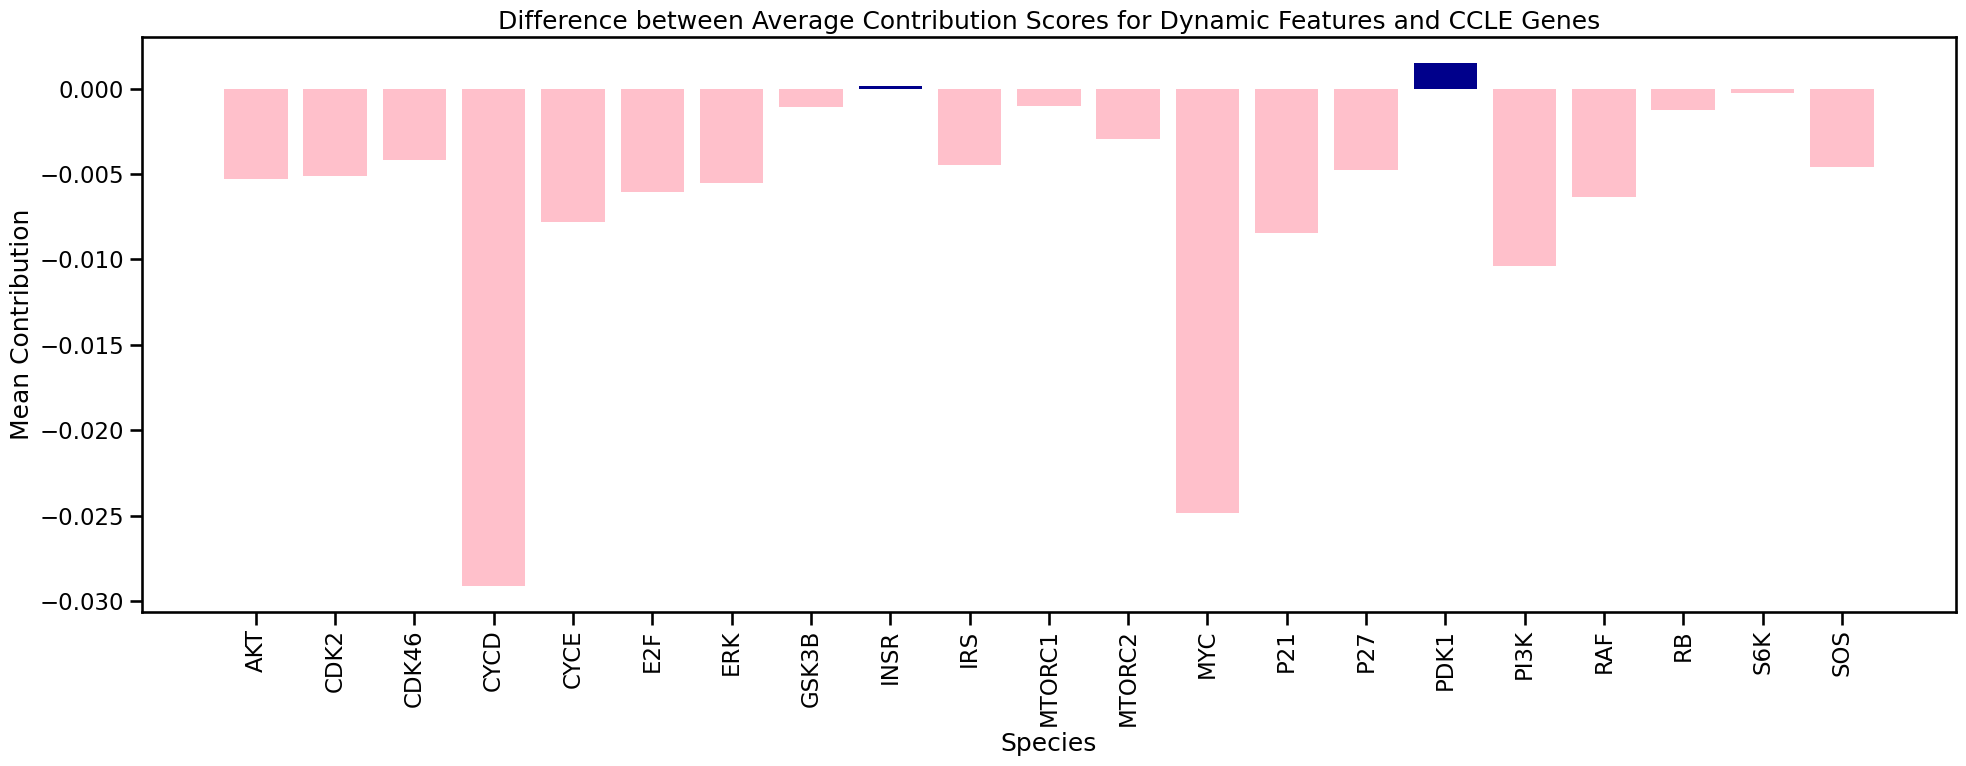

In [59]:
# find difference between the average scores for the dynamic features and the genes

diffs = []
for avg_dyn, avg_genes in zip(all_avgs_dyn, all_avgs_genes):
    diff = avg_dyn - avg_genes
    diffs.append(diff)
    
# plot the difference between the average scores for the dynamic features and the genes

sns.set_context('talk')
sns.set_palette('husl')

fig, a0 = plt.subplots(1, 1, figsize=(20, 8))

# a0.bar(species_ccle_matches.keys(), diffs)

# bar plot where the difference is positive, plot the bar in blue, otherwise in red
list_of_species = list(species_ccle_matches.keys())
for i, diff in enumerate(diffs):
    if diff > 0:
        a0.bar(list_of_species[i], diff, color='darkblue')
    else:
        a0.bar(list_of_species[i], diff, color='pink')

a0.set_title('Difference between Average Contribution Scores for Dynamic Features and CCLE Genes')
a0.set_ylabel('Mean Contribution')
a0.set_xlabel('Species')
a0.set_xticklabels(species_ccle_matches.keys(), rotation=90)

plt.tight_layout()
plt.show()